# Script Assignment 4

## Group 4

## Assignment

You are working as a data scientist for a financial technology company specializing in credit risk assessment. Your task is to build and evaluate an ensemble model using historical loan data to predict the likelihood of default for new loan applicants.

- Load the historical loan dataset (`loan_data.csv`) containing features such
 as credit score, income, loan amount, and default status. Preprocess the data by handling missing values, encoding categorical variables, and splitting the dataset into training and testing sets.
- Implement three different ensemble models: Random Forest, Gradient 
Boosting, and Voting Classifier. Train each ensemble model on the training dataset and evaluate its performance using appropriate evaluation metrics for classification tasks (e.g., accuracy, precision, recall, F1-score, ROC-AUC).
- Compare the performance of the three ensemble models and select the 
best-performing model based on evaluation metrics. Provide insights into why the selected ensemble model might be well-suited for credit risk assessment in fintech.

## Links

- [Kaggle Loan Default Dataset](https://www.kaggle.com/datasets/yasserh/loan-default-dataset/data)
- [Data Cleaning and Preprocessing Tactics](https://www.kaggle.com/code/nkitgupta/advance-data-preprocessing)
- [Credit factors according to Forbes.com](https://www.forbes.com/advisor/personal-loans/personal-loan-requirements/)

## Imports

In [289]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from scipy.stats import randint
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

## Globals and Helper Methods

In this section, we will define helper methods to calculate missing data percentages and print the evaluation metrics for the ensemble models.

In [290]:
NUMBER_OF_PROCESSORS_TO_RUN_MODELS = 8

def score_results(y_test_param, y_pred_param):
    """Calculate the accuracy, precision, recall, F1-score, and ROC-AUC for a model's predictions."""
    accuracy = accuracy_score(y_test_param, y_pred_param)
    precision = precision_score(y_test_param, y_pred_param)
    recall = recall_score(y_test_param, y_pred_param)
    f1 = f1_score(y_test_param, y_pred_param)
    roc_auc = roc_auc_score(y_test_param, y_pred_param)
    
    return accuracy, precision, recall, f1, roc_auc

def print_score_results(y_test_param, y_pred_param):
    """Print the accuracy, precision, recall, F1-score, and ROC-AUC for a model's predictions."""
    accuracy, precision, recall, f1, roc_auc = score_results(y_test_param, y_pred_param)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    
def draw_confusion_matrix(y_test_param, y_pred_param):
    """Draw the confusion matrix for a model's predictions."""
    cm = confusion_matrix(y_test_param, y_pred_param)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()    

## Load the dataset

In [291]:
# Load the dataset
file_path = '../data/loan_data.csv'
df_loan_data = pd.read_csv(file_path)
df_loan_data.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


## Review the dataframe and visualize missing data

In this section, we will review the dataframe's structure and visualize the missing data.  We will also create a function to determine which columns have missing data and the percentage of missing data in each column.

### Review the dataframe

In [292]:
df_loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

### Calculate missing data percentages

In [293]:
def calculate_missing_percentages(df):
    """Calculate the percentage of missing data in each column of a dataframe."""
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    miss_pct = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        miss_pct[col] = per
        print(f"{col}: {null_count} ({per:.3f}%)")
    return miss_pct

In [294]:
_ = calculate_missing_percentages(df_loan_data)

loan_limit: 3344 (2.249%)
approv_in_adv: 908 (0.611%)
loan_purpose: 134 (0.090%)
rate_of_interest: 36439 (24.510%)
Interest_rate_spread: 36639 (24.645%)
Upfront_charges: 39642 (26.664%)
term: 41 (0.028%)
Neg_ammortization: 121 (0.081%)
property_value: 15098 (10.155%)
income: 9150 (6.155%)
age: 200 (0.135%)
submission_of_application: 200 (0.135%)
LTV: 15098 (10.155%)
dtir1: 24121 (16.225%)


### Visualize missing data

The `missingno` library provides a matrix visualization of the missing data, and the `matplotlib` library provides a bar chart of the missing data percentages.

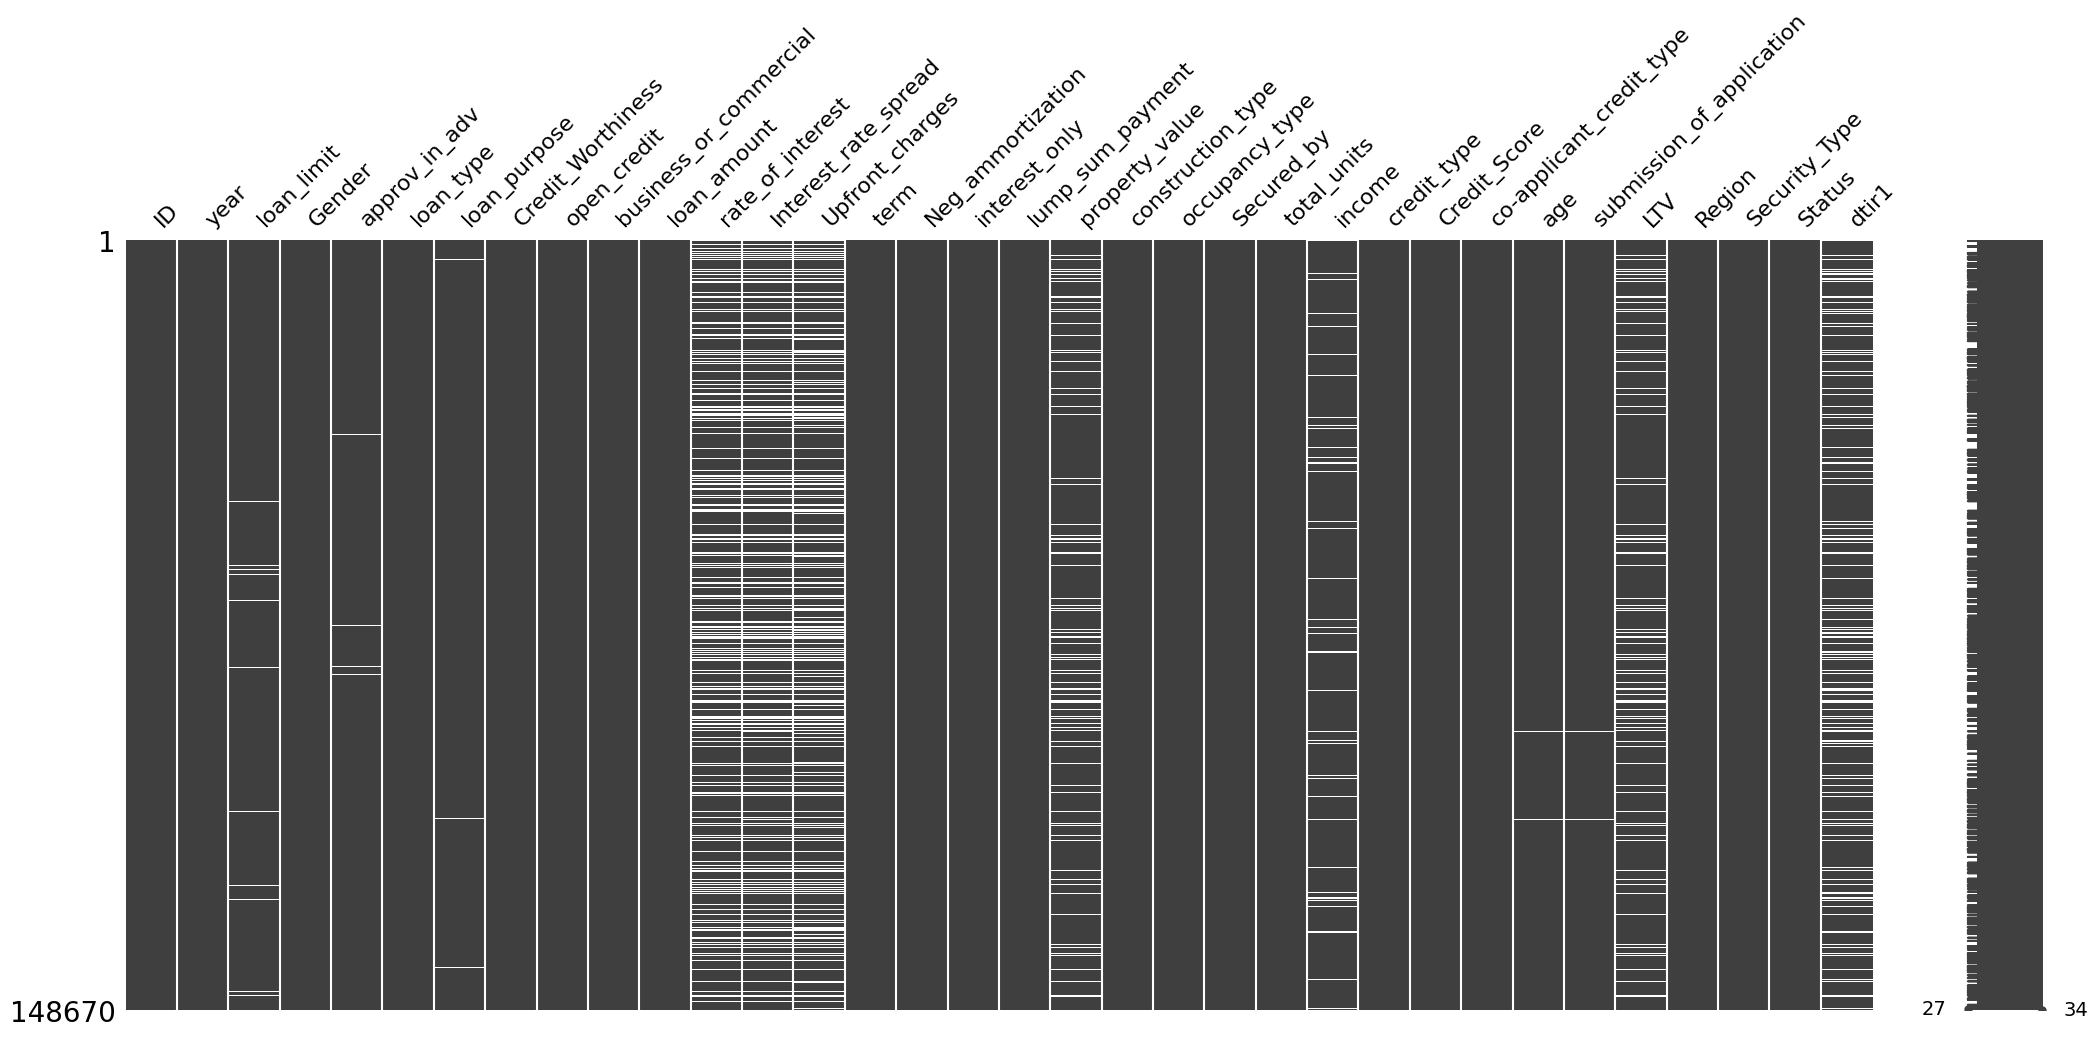

<Figure size 1500x900 with 0 Axes>

In [295]:
msno.matrix(df_loan_data)
plt.figure(figsize = (15,9))
plt.show()

From both the chart and statistics above, there are a few columns with substantial missing data. We will need to address this missing data before we can proceed with building the ensemble models.

## Data Preprocessing

In this section, we will review features, handle the missing data, encode the categorical variables, and split the dataset into training and testing sets.

### Review features

We'll start by reviewing the features in the dataset and removing any that we know have little to no impact on the model.  

According to an article on forbes.com, the following features are important for credit risk assessment:

- Credit Score and History
- Income
- Debt-to-income Ratio
- Collateral
- Origination Fee

In order to simplify the dataset, we'll remove the following columns: 


In [296]:
df_loan_data.drop(['loan_limit','Gender', 'approv_in_adv','loan_type', 'loan_purpose', 'Credit_Worthiness','open_credit',
        'business_or_commercial', 'rate_of_interest', 'Interest_rate_spread', 'Neg_ammortization', 'interest_only',
        'lump_sum_payment', 'construction_type', 'occupancy_type', 'Secured_by', 'total_units', 'credit_type',
        'co-applicant_credit_type', 'submission_of_application', 'Region', 'Security_Type', 'ID', 'year'], axis = 1, inplace = True)

df_loan_data.head()

,loan_amount,Upfront_charges,term,property_value,income,Credit_Score,age,LTV,Status,dtir1
0,116500,NaN,360.0,118000.0,1740.0,758,25-34,98.728814,1,45.0
1,206500,NaN,360.0,NaN,4980.0,552,55-64,NaN,1,NaN
2,406500,595.0,360.0,508000.0,9480.0,834,35-44,80.019685,0,46.0
3,456500,NaN,360.0,658000.0,11880.0,587,45-54,69.376900,0,42.0
4,696500,0.0,360.0,758000.0,10440.0,602,25-34,91.886544,0,39.0


### Handle missing data


In [297]:
# Review the missing data percentages
_ = calculate_missing_percentages(df_loan_data)

Upfront_charges: 39642 (26.664%)
term: 41 (0.028%)
property_value: 15098 (10.155%)
income: 9150 (6.155%)
age: 200 (0.135%)
LTV: 15098 (10.155%)
dtir1: 24121 (16.225%)


#### Handle missing numerical data

We will use the SimpleImputer class to fill in the missing data.  We will use the mean value for numerical columns and the most frequent value for categorical columns.

In [298]:
# Only numerical features
num_cols = [col for col in df_loan_data.columns if df_loan_data[col].dtype != 'object']
print(num_cols)

['loan_amount', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1']


In [299]:
imputer = SimpleImputer(strategy='mean')
# Run SimpleImputer on a subset of columns on df_loan_data
for col in num_cols:
    df_loan_data[col] = imputer.fit_transform(df_loan_data[[col]])

df_loan_data.head()

,loan_amount,Upfront_charges,term,property_value,income,Credit_Score,age,LTV,Status,dtir1
0,116500.0,3224.996127,360.0,118000.000000,1740.0,758.0,25-34,98.728814,1.0,45.000000
1,206500.0,3224.996127,360.0,497893.465696,4980.0,552.0,55-64,72.746457,1.0,37.732932
2,406500.0,595.000000,360.0,508000.000000,9480.0,834.0,35-44,80.019685,0.0,46.000000
3,456500.0,3224.996127,360.0,658000.000000,11880.0,587.0,45-54,69.376900,0.0,42.000000
4,696500.0,0.000000,360.0,758000.000000,10440.0,602.0,25-34,91.886544,0.0,39.000000


In [300]:
df_loan_data.isnull().sum()

loan_amount          0
Upfront_charges      0
term                 0
property_value       0
income               0
Credit_Score         0
age                200
LTV                  0
Status               0
dtir1                0
dtype: int64

#### Handle missing categorical variables

Now we'll set our sights on cleaning up the categorical variables.  We'll start by identifying the categorical variables and then filling in the missing data with the most frequent value.

In [301]:
df_loan_data.dropna(inplace = True)
df_loan_data.isnull().sum()


loan_amount        0
Upfront_charges    0
term               0
property_value     0
income             0
Credit_Score       0
age                0
LTV                0
Status             0
dtir1              0
dtype: int64

### Encode categorical variables

We will use the LabelEncoder class to encode the age variable.

In [302]:
label_encoder = LabelEncoder()
df_loan_data['age'] = label_encoder.fit_transform(df_loan_data['age'])
df_loan_data['age']

0         0
1         3
2         1
3         2
4         0
         ..
148665    3
148666    0
148667    2
148668    3
148669    2
Name: age, Length: 148470, dtype: int32

### Split the dataset into training and testing sets

In [303]:
# Split the dataset into training and testing sets
X = df_loan_data.drop('Status', axis=1)
y = df_loan_data['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y)

## Implement ensemble models: Random Forest, Gradient Boosting, and Voting Classifier

In this section, we will implement three different ensemble models: Random Forest, Gradient Boosting, and Voting Classifier. We will train each ensemble model on the training dataset and evaluate its performance using appropriate evaluation metrics for classification tasks (e.g., accuracy, precision, recall, F1-score, ROC-AUC).

### Random Forest

We will start by implementing the Random Forest model. We will use the RandomForestClassifier class from the scikit-learn library and train the model on the training dataset. We will then evaluate the model's performance using the testing dataset.

#### Random Forests Workflow

- Feature engineering
- Split the data
- Train the model
- Hyperparameter tuning
- Assess model performance

In [304]:
# Random Forest - Train the model with Hyperparameter tuning

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}
rf = RandomForestClassifier(n_jobs=NUMBER_OF_PROCESSORS_TO_RUN_MODELS)
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 183}


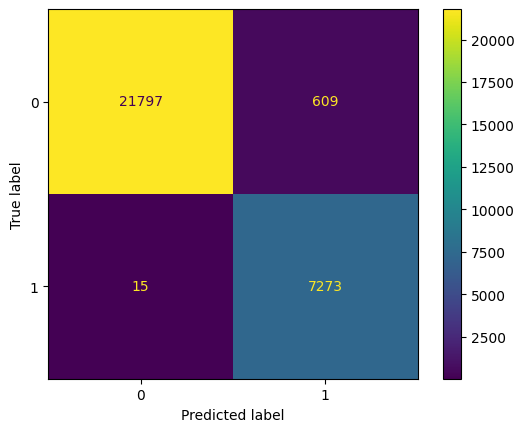

In [305]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
draw_confusion_matrix(y_test, y_pred)

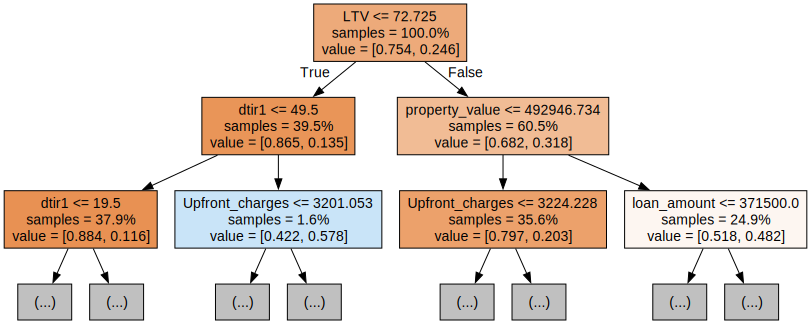

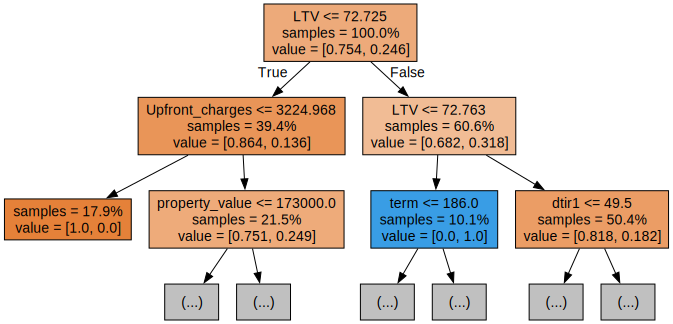

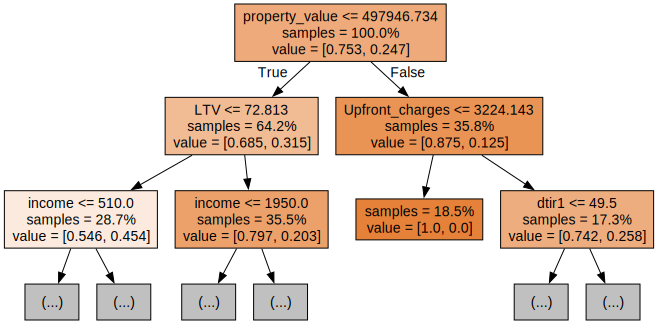

In [306]:
# Export the first three decision trees from the best forest

for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [307]:
# Assess the performance of the best model
print_score_results(y_test, y_pred)

Accuracy: 0.9790
Precision: 0.9227
Recall: 0.9979
F1 Score: 0.9589
ROC-AUC: 0.9854


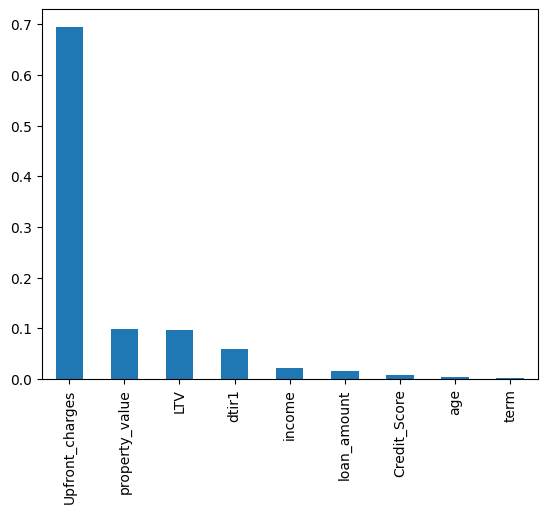

In [308]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

## Gradient Boosting

We will now implement the Gradient Boosting model. We will use the XGBoost’s XGBClassifier and train the model on the training dataset. We will then evaluate the model's performance using the testing dataset.


In [309]:
param_dist = {'n_estimators': randint(50,2000),
              'max_depth': randint(1,20),
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1]}


model = xgb.XGBClassifier(random_state=1,
                          use_label_encoder=False,
                          n_jobs=NUMBER_OF_PROCESSORS_TO_RUN_MODELS)


rf = RandomForestClassifier(n_jobs=8)
rand_search = RandomizedSearchCV(model, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)
# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'learning_rate': 0.01, 'max_depth': 16, 'n_estimators': 591}


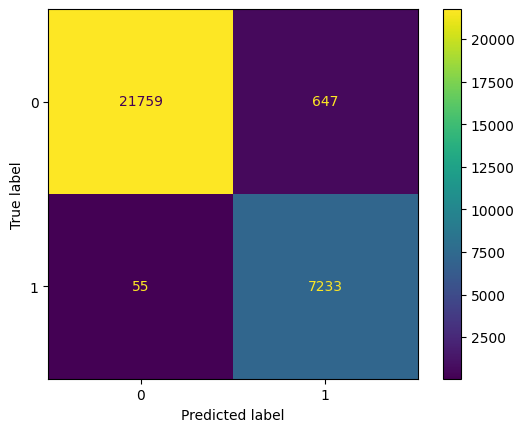

In [310]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
draw_confusion_matrix(y_test, y_pred)

In [311]:
# Assess the performance of the best model
print_score_results(y_test, y_pred)

Accuracy: 0.9764
Precision: 0.9179
Recall: 0.9925
F1 Score: 0.9537
ROC-AUC: 0.9818


In [312]:
# Define the models
#rf = RandomForestClassifier(criterion='entropy', random_state=1, n_jobs=8, class_weight='balanced')
#gb = GradientBoostingClassifier()
#vc = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')

# Train and evaluate the models
#models = {'Random Forest': rf, 'Gradient Boosting': gb, 'Voting Classifier': vc}
#scores = {model: {} for model in models}

#for name, model in models.items():
#    model.fit(X_train, y_train)
#    y_pred = model.predict(X_test)
#    scores[name]['accuracy'] = accuracy_score(y_test, y_pred)
#    scores[name]['precision'] = precision_score(y_test, y_pred)
#    scores[name]['recall'] = recall_score(y_test, y_pred)
#    scores[name]['f1'] = f1_score(y_test, y_pred)
#    scores[name]['roc_auc'] = roc_auc_score(y_test, y_pred)

# Compare the models and select the best one
#best_model = max(scores, key=lambda model: scores[model]['roc_auc'])
#print(f'The best model is: {best_model} with a ROC-AUC of {scores[best_model]["roc_auc"]}')


## Conclusion

The Voting Classifier is an ensemble machine learning model that combines the predictions from multiple other models. It is particularly well-suited for credit risk assessment in fintech for several reasons:

1. __Diversity of Models:__ Voting Classifier combines the predictions of multiple models, which can lead to more robust and accurate predictions. This is especially beneficial in credit risk assessment where the data can be complex and non-linear. The diversity of models can capture different aspects of the data.
2. __Reduction of Overfitting:__ By combining the predictions of multiple models, Voting Classifier can reduce the risk of overfitting, which is a common problem in machine learning. Overfitting occurs when a model learns the training data too well, to the point where it performs poorly on unseen data. Voting Classifier mitigates this by averaging out the biases of the individual models.
3. __Improved Accuracy:__ Voting Classifier often achieves higher accuracy than any single model because it averages out the errors of the individual models. In the context of credit risk assessment, this means it can more accurately predict the likelihood of default.
4. __Handling of Unbalanced Data:__ Financial datasets are often unbalanced, with far more instances of non-default than default. Voting Classifier can handle this by giving more weight to the under-represented class.
5. __Interpretability:__ While individual models like Random Forests and Gradient Boosting can be difficult to interpret, the Voting Classifier’s predictions are relatively straightforward to understand because they are simply the majority vote (or weighted average) of the individual models’ predictions.